In [1]:
import pandas as pd

df = pd.read_csv("data/raw/telco_churn.csv")
print(df.shape)
df.head()


(7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [2]:
df.columns


Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [3]:
# Make a copy
df = df.copy()

# Convert target to numbers
df["Churn"] = df["Churn"].map({"Yes": 1, "No": 0})

# Fix TotalCharges (it is stored as text sometimes)
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

# Remove customerID (not useful for prediction)
df = df.drop(columns=["customerID"])

# Remove rows with missing values
df = df.dropna()

df.head()


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1


In [4]:
df["Churn"].value_counts()


Churn
0    5163
1    1869
Name: count, dtype: int64

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression


In [6]:
# Separate input and target
X = df.drop("Churn", axis=1)
y = df["Churn"]

# Identify categorical and numerical columns
cat_cols = X.select_dtypes(include=["object"]).columns
num_cols = X.select_dtypes(exclude=["object"]).columns

# Create preprocessing steps
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

# Create model pipeline
model = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=2000))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Training data size:", X_train.shape)
print("Testing data size:", X_test.shape)


Training data size: (5625, 19)
Testing data size: (1407, 19)


In [7]:
# Train the model
model.fit(X_train, y_train)

print("Model training complete!")


Model training complete!


In [8]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score

# Predictions
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

# Metrics
accuracy = accuracy_score(y_test, y_pred)
roc = roc_auc_score(y_test, y_prob)
cm = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("ROC-AUC Score:", roc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", cm)


Accuracy: 0.7874911158493249
ROC-AUC Score: 0.8319778848792002

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.62      0.52      0.56       374

    accuracy                           0.79      1407
   macro avg       0.73      0.70      0.71      1407
weighted avg       0.78      0.79      0.78      1407


Confusion Matrix:
 [[915 118]
 [181 193]]


In [9]:
# Get feature names after preprocessing
ohe = model.named_steps["preprocess"].named_transformers_["cat"]
cat_features = ohe.get_feature_names_out(cat_cols)

all_features = list(num_cols) + list(cat_features)

# Get model coefficients
coefficients = model.named_steps["classifier"].coef_[0]

feature_importance = pd.DataFrame({
    "Feature": all_features,
    "Importance": coefficients
})

feature_importance = feature_importance.sort_values(by="Importance", ascending=False)

feature_importance.head(10)


,Feature,Importance
3,TotalCharges,0.693367
36,Contract_Month-to-month,0.593206
16,InternetService_Fiber optic,0.529253
43,PaymentMethod_Electronic check,0.172585
18,OnlineSecurity_No,0.168185
35,StreamingMovies_Yes,0.161687
27,TechSupport_No,0.153964
32,StreamingTV_Yes,0.153941
0,SeniorCitizen,0.094692
14,MultipleLines_Yes,0.023836


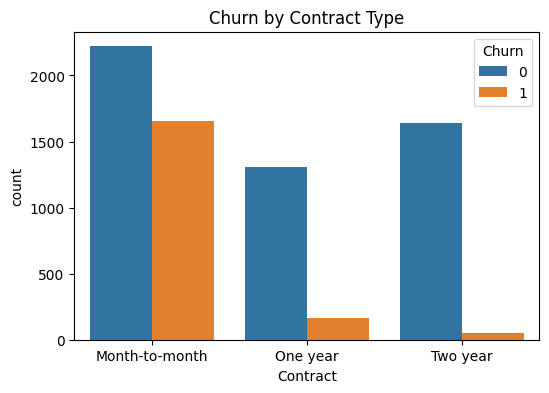

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(data=df, x="Contract", hue="Churn")
plt.title("Churn by Contract Type")
plt.show()


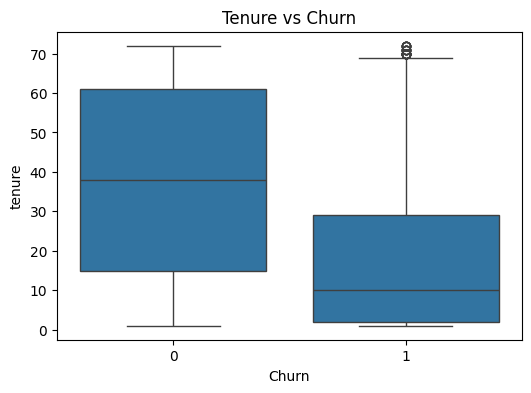

In [11]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Churn", y="tenure")
plt.title("Tenure vs Churn")
plt.show()


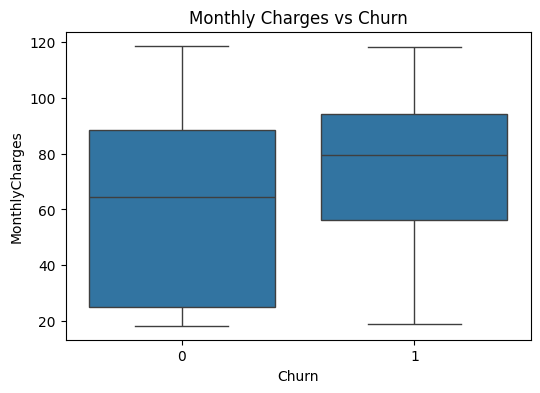

In [12]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df, x="Churn", y="MonthlyCharges")
plt.title("Monthly Charges vs Churn")
plt.show()


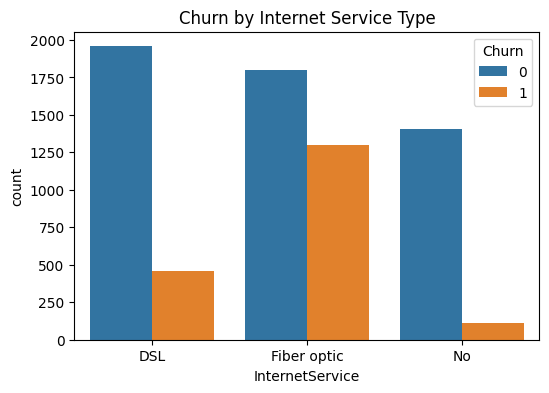

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(data=df, x="InternetService", hue="Churn")
plt.title("Churn by Internet Service Type")
plt.show()


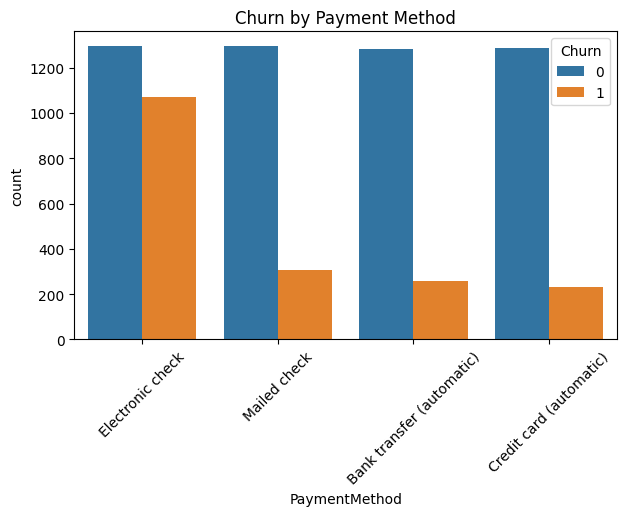

In [14]:
plt.figure(figsize=(7,4))
sns.countplot(data=df, x="PaymentMethod", hue="Churn")
plt.xticks(rotation=45)
plt.title("Churn by Payment Method")
plt.show()


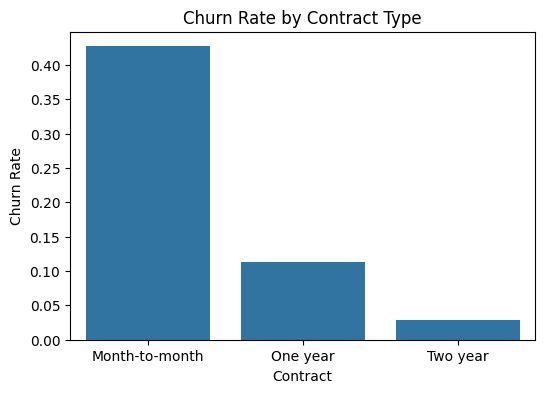

In [15]:
churn_rate = df.groupby("Contract")["Churn"].mean().reset_index()

plt.figure(figsize=(6,4))
sns.barplot(data=churn_rate, x="Contract", y="Churn")
plt.title("Churn Rate by Contract Type")
plt.ylabel("Churn Rate")
plt.show()


In [16]:
# Predict churn probability for ALL customers
all_probs = model.predict_proba(X)[:, 1]

df["Churn_Probability"] = all_probs

# High-risk customers = probability > 0.7
high_risk = df[df["Churn_Probability"] > 0.7]

# Estimate revenue at risk
revenue_at_risk = high_risk["MonthlyCharges"].sum()

print("Number of high-risk customers:", len(high_risk))
print("Estimated Monthly Revenue at Risk: $", round(revenue_at_risk, 2))


Number of high-risk customers: 480
Estimated Monthly Revenue at Risk: $ 40864.1


In [17]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.2 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
